In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Data

In [21]:
# Hospitalizations
data_hosp = [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7,
    0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14,
    27), (15, 97), (16, 163), (17, 265), (18, 368), (19, 496), (20,
    649), (21, 842), (22, 1097), (23, 1381), (24, 1644), (25,
    1881), (26, 2138), (27, 2718), (28, 3072), (29, 3644), (30,
    4081), (31, 4474), (32, 4886), (33, 4979), (34, 5210), (35,
    5362), (36, 5497), (37, 5514), (38, 5606), (39, 5744), (40,
    5699), (41, 5597), (42, 5618), (43, 5645), (44, 5419), (45,
    5423), (46, 5536), (47, 5515), (48, 5309), (49, 5161), (50,
    5069), (51, 4871), (52, 4920), (53, 4976)]
    
# ICUs
data_icu = [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7,
    0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 2), (14,
    15), (15, 24), (16, 33), (17, 53), (18, 79), (19, 100), (20,
    130), (21, 164), (22, 238), (23, 290), (24, 322), (25, 381), (26,
    474), (27, 605), (28, 690), (29, 789), (30, 867), (31, 927), (32,
    1021), (33, 1088), (34, 1144), (35, 1205), (36, 1245), (37,
    1261), (38, 1267), (39, 1260), (40, 1276), (41, 1285), (42,
    1278), (43, 1262), (44, 1232), (45, 1234), (46, 1226), (47,
    1204), (48, 1182), (49, 1140), (50, 1119), (51, 1081), (52,
    1071), (53, 1079)]
    
# Daily deaths
data_death = [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7,
    0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 1), (14,
    3), (15, 3), (16, 5), (17, 5), (18, 10), (19, 10), (20, 19), (21,
    25), (22, 27), (23, 36), (24, 46), (25, 75), (26, 69), (27,
    91), (28, 91), (29, 115), (30, 128), (31, 133), (32, 158), (33,
    172), (34, 238), (35, 193), (36, 224), (37, 269), (38, 225), (39,
    267), (40, 299), (41, 321), (42, 275), (43, 323), (44, 283), (45,
    338), (46, 270), (47, 262), (48, 266), (49, 240), (50, 191), (51,
    98), (52, 22), (53, 170)]

# Convert to pandas 
data = pd.DataFrame({
    "n_hospitalized": [i for _ , i in data_hosp],
    "n_icu": [i for _, i in data_icu],
    "n_daily_deaths": [i for _, i in data_death]
}, index=range(1, 53+1))

data["n_deaths"] = data["n_daily_deaths"].cumsum()

In [3]:
data.head(20)

,n_hospitalized,n_icu,n_daily_deaths,n_deaths
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
5,0,0,0,0
6,0,0,0,0
7,0,0,0,0
8,0,0,0,0
9,0,0,0,0
10,0,0,0,0


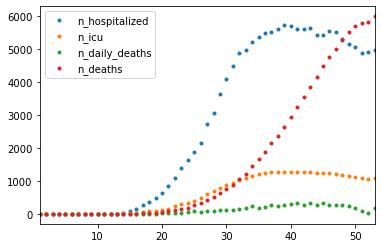

In [4]:
data.plot(style=".")

In [5]:
data.describe()

,n_hospitalized,n_icu,n_daily_deaths,n_deaths
count,53.000000,53.000000,53.000000,53.000000
mean,2765.905660,610.245283,113.132075,1603.792453
std,2428.728809,541.806377,116.544154,2057.325629
min,0.000000,0.000000,0.000000,0.000000
25%,27.000000,15.000000,3.000000,4.000000
50%,2718.000000,605.000000,75.000000,425.000000
75%,5309.000000,1182.000000,225.000000,2937.000000
max,5744.000000,1285.000000,338.000000,5996.000000


# SEIR model

Python re-implementation of Nicolas' original SEIR model.

In [6]:
# Parameters
frac_dh = 2655 / 5828  # deaths in hospitals / total deaths
window = 6          # size of the window for fitting Re's
hh = 0.05           # fraction of hospitalized 
gamma = 1 / 12.4   # inverse recovery time
epsilon = 1 / 5.2   # inverse incubation time 
dea = 0.5           # fatality rate in icu 
n0 = 11000000       # population size
n0_MRS = 400000     # Population en MR/MRS + personnel soignant

In [7]:
def SEIR(r0, i0=3, gg=0.75):
    n_days = len(r0)
    
    drea = dea * 1 / 5
    rrea = (1 - dea) * 1 / 20
    n = [n0]
    i = [i0]
    e = [i[-1] * 37]
    h = [0.0]
    l = [0.0]
    r = [0.0]
    m = [0.0]
    s = [n[-1] - e[-1] - i[-1] - r[-1]]
    hospi = 0.0
    
    for day in range(n_days):
        lam = gamma * r0[day]
        
        if day == 14:
            hospi = hh / 7
            
        ds = -lam * (i[-1] / 2 + e[-1]) * s[-1] / n[-1]
        de = lam * (i[-1] / 2 + e[-1]) * s[-1] / n[-1] - epsilon * e[-1]
        di = epsilon * e[-1] - gamma * i[-1] - hospi * i[-1]
        dh = hospi * i[-1] - gg * h[-1] / 7 - (1 - gg) * h[-1] / (4 + 2 * np.tanh((l[-1]-500)/300))
        dl = (1 - gg) * h[-1] / (4 + 2 * np.tanh((l[-1]-500)/300)) - drea * l[-1] - rrea * l[-1]
        dr = gamma * i[-1] + rrea * l[-1] + gg * h[-1] / 7
        dm = drea * l[-1] 
        
        s.append(s[-1] + ds)
        e.append(e[-1] + de)
        i.append(i[-1] + di)
        h.append(h[-1] + dh)
        l.append(l[-1] + dl)
        if l[-1] > 1895:
            dm = dm + (l[-1] - 1895)
            l[-1] = 1895
        r.append(r[-1] + dr)
        m.append(m[-1] + dm)
        n.append(s[-1] + e[-1] + i[-1] + h[-1] + l[-1] + r[-1])
        
    return np.array(s), np.array(e), np.array(i), np.array(h), np.array(l), np.array(m), np.array(r)

def SEIR_MRS(r0_mrs):
    n_days = len(r0_mrs)
    
    alpha = 0.15 / 10
    lam = gamma * 4.3
    n = [n0_MRS]
    i = [1]
    e = [i[-1]*20]
    r = [0.0]
    s = [n[-1] - e[-1] - i[-1] - r[-1]]
    m = [0.0]
    
    for day in range(n_days):
        lam = gamma * r0_mrs[day]
        
        ds = -lam * (i[-1] / 2 + e[-1]) * s[-1] / n[-1]
        de = lam * (i[-1] / 2 + e[-1]) * s[-1] / n[-1] - epsilon * e[-1]
        di = epsilon * e[-1] - (gamma + alpha) * i[-1]
        dr = gamma * i[-1]
        dm = alpha * i[-1]
        
        s.append(s[-1] + ds)
        e.append(e[-1] + de)
        i.append(i[-1] + di)
        r.append(r[-1] + dr)
        m.append(m[-1] + dm)
        n.append(s[-1] + e[-1] + i[-1] + r[-1])
        
    return np.array(s), np.array(e), np.array(i), np.array(m), np.array(r)

# Parameter fit

The procedure is different from Nicolas'. All parameters are fit jointly, instead of using a greedy procedure to fit parameters sequentially. Results are therefore slightly different.

In [8]:
from scipy.optimize import minimize

In [9]:
def pack(r0, r0_rms, i0, gg):
    v = np.zeros(len(r0) + len(r0_rms) + 2)
    v[:len(r0)] = r0
    v[len(r0):len(r0)+len(r0_rms)] = r0_rms
    v[-2] = i0
    v[-1] = gg
    return v 

def unpack(v):
    return v[:(len(v)-2)//2], v[(len(v)-2)//2:len(v)-2], v[-2], v[-1]

def smoothen(v, n_pts=3):
    box = np.ones(n_pts) / n_pts
    return np.convolve(v, box, mode="same")

In [10]:
def cost(x):
    # parameters
    r0, r0_mrs, i0, gg = unpack(x)
    
    # smoothen the values
    # --> kind of "compensate" for the greedy procedure and coarse grid
    r0 = smoothen(r0)
    r0_mrs = smoothen(r0_mrs)
    
    # make the last r0s identical
    r0 = np.concatenate((r0, np.array([r0[-1]] * window)))
    r0_mrs = np.concatenate((r0_mrs, np.array([r0_mrs[-1]] * window)))
    
    c = 0.0
    
    # fit on hosp+icus+deaths with SEIR
    s, e, i, h, l, m, r = SEIR(r0, i0=i0, gg=gg)
    
    c += ((h[10:]+l[10:] - data["n_hospitalized"].values[9:]) ** 2).sum()
    c += ((l[10:] - data["n_icu"].values[9:]) ** 2).sum()
    c += ((m[10:] - frac_dh * data["n_deaths"].values[9:]) ** 2).sum()
    
    # fit on deaths with SEIR_MRS
    s, e, i, m_mrs, r = SEIR_MRS(r0_mrs)
    c += ((m_mrs[1:] - (data["n_deaths"].values - m[1:])) ** 2).sum()

    return c
 
    
r0 = [4.3] * (len(data) - window)
r0_rms = [4.3] * (len(data) - window)
i0 = 3.0
gg = 0.75

bounds = []
for _ in range(len(r0)):
    bounds.append((0.3, 5.0))
for _ in range(len(r0_rms)):
    bounds.append((0.3, 6.3))
bounds.append((1, 50))
bounds.append((0.65, 0.85))

x0 = pack(r0, r0_rms, i0, gg)

res = minimize(cost, x0=x0, bounds=bounds, options={"maxfun": 100000})

In [11]:
res

      fun: 1106414.729508543
 hess_inv: <96x96 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.91926107e+03,  1.02621503e+04,  9.94962174e+03,  9.85935330e+03,
        9.68787353e+03,  9.53790732e+03,  9.46589280e+03,  9.44333151e+03,
        9.50130634e+03,  9.54472926e+03,  9.59236640e+03,  9.54938587e+03,
        9.56116710e+03,  9.58405435e+03,  9.65024810e+03,  9.70703550e+03,
        9.85173974e+03,  1.01905782e+04,  1.07538886e+04,  1.13963615e+04,
        1.17756892e+04,  1.16659328e+04,  1.15572708e+04,  1.32210786e+04,
        1.87238213e+04,  2.75764149e+04,  3.71404691e+04,  4.36003786e+04,
        4.52186447e+04,  4.16744268e+04,  3.40812607e+04,  2.49708770e+04,
        1.64948869e+04,  1.02697872e+04,  6.24540262e+03,  4.32722736e+03,
        3.75604723e+03,  3.56729142e+03,  3.20554245e+03,  2.92547047e+03,
        3.03585548e+03,  3.44042201e+03,  4.21314035e+03,  4.92790714e+03,
        4.68243379e+03, -1.90143473e+03, -3.77155375e+03, -5.62425703e+02,
  

In [12]:
r0, r0_mrs, i0, gg = unpack(res.x)
print(r0)
print(r0_mrs)
print(i0)
print(gg)

[4.81233051 3.93706454 3.71355682 4.28800121 4.54353424 4.80313189
 5.         4.92630244 4.77855459 4.96365728 4.06841161 4.94287191
 4.82164796 4.50091974 4.16355276 3.81263744 3.49179967 3.2007343
 3.12591972 3.1499533  3.31601342 3.59731737 3.81228034 3.5527711
 2.34816459 0.3        0.3        0.3        0.3        0.3
 0.3        0.3        0.3        0.31454162 0.50634163 0.52622973
 1.06036081 1.02712952 1.27672926 1.3458961  1.21078587 0.95714347
 0.66015538 0.43634955 0.49103502 1.097135   1.97052091]
[4.45902243 5.78045277 4.49136752 4.51094436 4.5370199  4.57663665
 4.60765583 4.61057985 4.46876269 4.34019755 4.22605393 4.12812714
 4.04405636 3.97570656 3.91998594 3.87479978 3.84621597 3.82517323
 3.81358152 3.81278619 3.81205085 3.8139263  3.8100004  3.8064672
 3.79184475 3.76541673 3.72449734 3.65821705 3.55810384 3.25813602
 3.01091925 2.67561266 2.24701283 1.71025286 1.06512868 0.33391845
 0.33870057 0.30006628 0.3        0.3        0.3        0.3
 0.3        0.3       

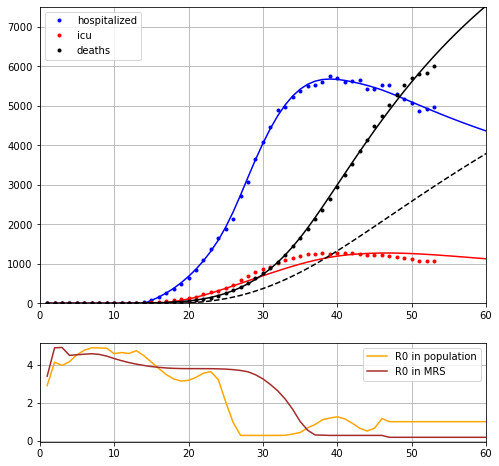

In [13]:
# Plots
r0, r0_mrs, i0, gg = unpack(res.x)
r0 = smoothen(r0)
r0_mrs = smoothen(r0_mrs)

n_futures = 60
r0 = np.concatenate((r0, np.array([r0[-1]] * (window + n_futures))))
r0_mrs = np.concatenate((r0_mrs, np.array([r0_mrs[-1]] * (window + n_futures))))
s, e, i, h, l, m, r = SEIR(r0, i0=i0, gg=gg)
_, _, _, m_mrs, _ = SEIR_MRS(r0_mrs)

n_days = len(data)

fig, ax = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={"height_ratios": (3,1)})

ax[0].plot(range(1, n_days+1 + n_futures), h[1:]+l[1:], c="b")
ax[0].plot(range(1, n_days+1), data["n_hospitalized"].values, ".", c="b", label="hospitalized")
ax[0].plot(range(1, n_days+1 + n_futures), l[1:], c="r")
ax[0].plot(range(1, n_days+1), data["n_icu"].values, ".", c="r", label="icu")
ax[0].plot(range(1, n_days+1 + n_futures), m[1:] + m_mrs[1:], c="k")
ax[0].plot(range(1, n_days+1 + n_futures), m[1:], "--", c="k")
ax[0].plot(range(1, n_days+1), data["n_deaths"].values, ".", c="k", label="deaths")
ax[0].grid()
ax[0].set_ylim(0, 7500)
ax[0].set_xlim(0, 60)
ax[0].legend()

ax[1].plot(range(1, n_days+1 + n_futures), r0, c="orange", label="R0 in population")
ax[1].plot(range(1, n_days+1 + n_futures), r0_mrs, c="brown", label="R0 in MRS")
ax[1].grid()
ax[1].set_xlim(0, 60)
ax[1].legend()

plt.savefig("nicolas-reimpl.png")
plt.show()


# Parametric Bootsrap

We suppose the following noise model:
- $h_t \sim \mathcal{P}(\lambda_{h_t})$
- $icu_t \sim \mathcal{P}(\lambda_{icu_t})$
- $d_t \sim \mathcal{P}(\lambda_{d_t})$

In [14]:
# Meta Parameters:
r_smoothing = True # Smoothing r_0 values?
# Parameters
frac_dh = 2655 / 5828  # deaths in hospitals / total deaths
window = 6          # size of the window for fitting Re's
hh = 0.05           # fraction of hospitalized 
gamma = 1 / 12.4   # inverse recovery time
epsilon = 1 / 5.2   # inverse incubation time 
dea = 0.5           # fatality rate in icu 
n0 = 11000000       # population size
n0_MRS = 400000     # Population en MR/MRS + personnel soignant

In [15]:
def param_bootstrap(fit_function, sim_function, data, nb_iter=1000):
    theta_hat = fit_function(data)
    thetas_bootstrap = []
    all_data = []
    for i in range(nb_iter):
        sim_data = sim_function(theta_hat)
        all_data.append(sim_data)
        thetas_bootstrap.append(fit_function(sim_data))
    return thetas_bootstrap, all_data

In [35]:
def seir_fit_function(data):
    def cost(x):
        # parameters
        r0, r0_mrs, i0, gg = unpack(x)

        # smoothen the values
        # --> kind of "compensate" for the greedy procedure and coarse grid
        if r_smoothing:
            r0 = smoothen(r0)
            r0_mrs = smoothen(r0_mrs)

        # make the last r0s identical
        r0 = np.concatenate((r0, np.array([r0[-1]] * window)))
        r0_mrs = np.concatenate((r0_mrs, np.array([r0_mrs[-1]] * window)))

        c = 0.0

        # fit on hosp+icus+deaths with SEIR
        s, e, i, h, l, m, r = SEIR(r0, i0=i0, gg=gg)

        c += ((h[10:]+l[10:] - data["n_hospitalized"].values[9:]) ** 2).sum()
        c += ((l[10:] - data["n_icu"].values[9:]) ** 2).sum()
        c += ((m[10:] - frac_dh * data["n_deaths"].values[9:]) ** 2).sum()

        # fit on deaths with SEIR_MRS
        s, e, i, m_mrs, r = SEIR_MRS(r0_mrs)
        c += ((m_mrs[1:] - (data["n_deaths"].values - m[1:])) ** 2).sum()

        return c

    
    r0 = [4.3] * (len(data) - window)
    r0_rms = [4.3] * (len(data) - window)
    i0 = 3.0
    gg = 0.75

    bounds = []
    for _ in range(len(r0)):
        bounds.append((0.3, 5.0))
    for _ in range(len(r0_rms)):
        bounds.append((0.3, 6.3))
    bounds.append((1, 50))
    bounds.append((0.65, 0.85))

    x0 = pack(r0, r0_rms, i0, gg)

    res = minimize(cost, x0=x0, bounds=bounds, options={"maxfun": 10000})
    r0, r0_mrs, i0, gg = unpack(res.x)
    return [r0, r0_mrs, i0, gg]

In [36]:
def seir_sim(theta, n_futures=-1):
    r0, r0_mrs, i0, gg = theta
    r0 = np.concatenate((r0, np.array([r0[-1]] * (window + n_futures))))
    r0_mrs = np.concatenate((r0_mrs, np.array([r0_mrs[-1]] * (window + n_futures))))
    s, e, i, h, l, m, r = SEIR(r0, i0=i0, gg=gg)
    _, _, _, m_mrs, _ = SEIR_MRS(r0_mrs)
    noise_f = np.random.poisson
    data = pd.DataFrame({
        "n_hospitalized": noise_f(h + l),
        "n_icu": noise_f(l),
        "n_deaths": noise_f(m + m_mrs)
    }, index=range(1, 53+2 + n_futures))
    # add poisson
    return data

In [40]:
thetas_bootstrap, all_data = param_bootstrap(seir_fit_function, seir_sim, data, nb_iter=50)

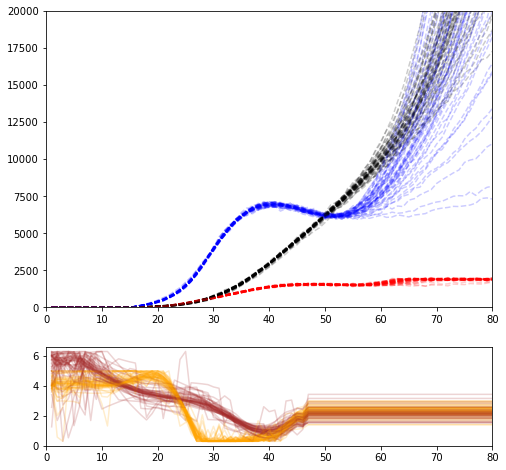

In [45]:
n_futures = 30
alpha=0.2
fig, ax = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={"height_ratios": (3,1)})
for theta in thetas_bootstrap:
    data_sim = seir_sim(theta, n_futures)
    n_days = len(data_sim)
    
    r0, r0_mrs, i0, gg = theta
    r0 = np.concatenate((r0, np.array([r0[-1]] * (window + n_futures))))
    r0_mrs = np.concatenate((r0_mrs, np.array([r0_mrs[-1]] * (window + n_futures))))

    ax[0].plot(range(1, n_days+1), data_sim["n_hospitalized"].values, "--", c="b", label="hospitalized", alpha=alpha)
    ax[0].plot(range(1, n_days+1), data_sim["n_icu"].values, "--", c="r", label="icu", alpha=alpha)
    ax[0].plot(range(1, n_days+1), data_sim["n_deaths"].values, "--", c="k", label="deaths", alpha=alpha)
    ax[0].grid()
    ax[0].set_ylim(0, 20000)
    ax[0].set_xlim(0, 80)
    #ax[0].legend()

    ax[1].plot(range(1, n_days), r0, c="orange", label="R0 in population", alpha=alpha)
    ax[1].plot(range(1, n_days), r0_mrs, c="brown", label="R0 in MRS", alpha=alpha)
    ax[1].grid()
    ax[1].set_xlim(0, 80)
    #ax[1].legend()

plt.savefig("nicolas-reimpl-bootstrap.png")
plt.show()


In [39]:
thetas_bootstrap

[[array([3.96204311, 4.36511757, 4.36804555, 4.32962607, 4.28860502,
         4.24494519, 4.20833657, 4.16977809, 4.14176923, 4.10495553,
         4.08604479, 4.07856654, 4.0989832 , 4.15677435, 4.23411736,
         4.32631762, 4.41738835, 4.49271391, 4.52987939, 4.47317867,
         4.31628517, 4.01434858, 3.53921672, 2.89823729, 2.10900318,
         1.25009641, 0.39368628, 0.3       , 1.83919195, 0.3       ,
         0.3       , 0.3       , 0.3       , 0.3       , 0.3866236 ,
         0.32242686, 0.38529464, 0.3       , 0.73902902, 0.83249546,
         1.00681774, 1.16946253, 1.33890339, 1.56796699, 1.84086368,
         1.8584766 , 2.26086284]),
  array([5.99296232, 5.27785285, 5.06497207, 5.19652588, 5.31183109,
         5.74099055, 5.60291148, 5.33487163, 5.05235281, 4.79494024,
         4.56308384, 4.35023964, 4.1570187 , 3.98590891, 3.83734489,
         3.70237154, 3.59187256, 3.49615433, 3.4168771 , 3.34443619,
         3.28346754, 3.22746891, 3.17720675, 3.14948114, 3.14956772,